# Test the hologram performances with PNG321.0+3.9
==================================================================================================

- author : Jérémy Neveu
- date   : June 5th 2017


In [1]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

print theNotebook
from IPython.display import Image, display
import sys
sys.path.append("../../common_tools/")
from common_notebook import *

init_notebook()

FullAnalysis
ccdproc version 1.2.0
bottleneck version 1.2.0
/Users/jneveu/Documents/LSST/Calibration/CTIOAnaJun2017/ana_05jun17/PNG321.0+3.9


### Input directory

In [50]:
#inputdir="../OverScanRemove/trim_images"
inputdir="../../data/CTIODataJune2017_reducedRed/data_05jun17/"
MIN_IMGNUMBER=26
MAX_IMGNUMBER=29
date="20170605"
object_name='PNG321.0+3.9'
tag = "reduc"
SelectTagRe='^%s_%s_([0-9]+).fits$' % (tag,date) # regular expression to select the file
SearchTagRe='^%s_%s_[0-9]+.fits$' % (tag,date)
NBIMGPERROW=2

### Output directories

In [51]:
dir_top_images="images_notebooks/"+theNotebook ### Top directory to save images
ensure_dir(dir_top_images) # create that directory

outputdir="./cut_fitsimages"
ensure_dir(outputdir)

## Location of the spectra
----------------------------------

In [52]:
dirlist_all = [inputdir]
sorted_numbers,sorted_files = MakeFileList(dirlist_all,MIN_IMGNUMBER,MAX_IMGNUMBER,SelectTagRe,SearchTagRe) 

all_dates,all_airmass,all_images,all_titles,all_header,all_expo,all_filt=BuildImages(sorted_files,sorted_numbers,object_name)

print 'Number of images:',len(all_images)

Number of images: 4


### Show images

Processing image 0...
Processing image 1...
Processing image 2...
Processing image 3...


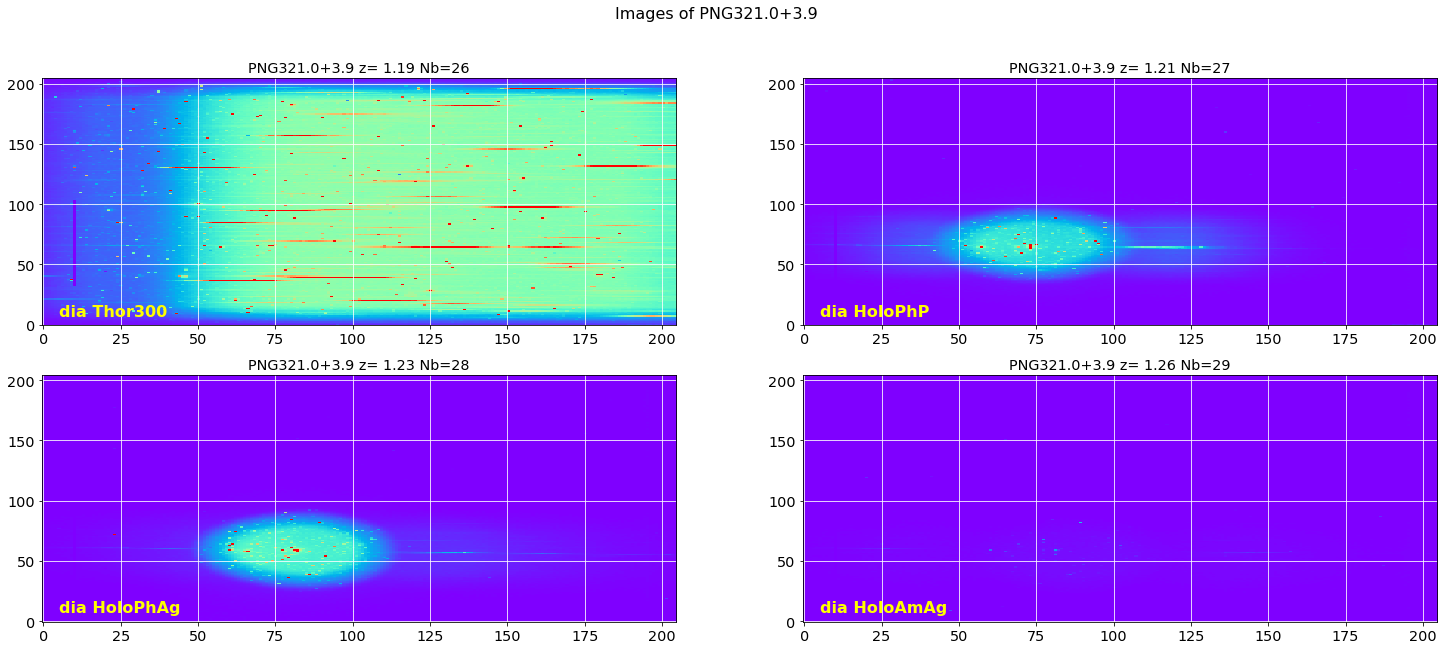

In [7]:
ShowImages(all_images,all_titles,all_filt,object_name,NBIMGPERROW=2,vmin=0,vmax=10000,downsampling=10,verbose=True)

figfilename=os.path.join(dir_top_images,'input_images.pdf')
plt.savefig(figfilename)   

### Show histograms

Processing image 0...
Processing image 1...
Processing image 2...
Processing image 3...


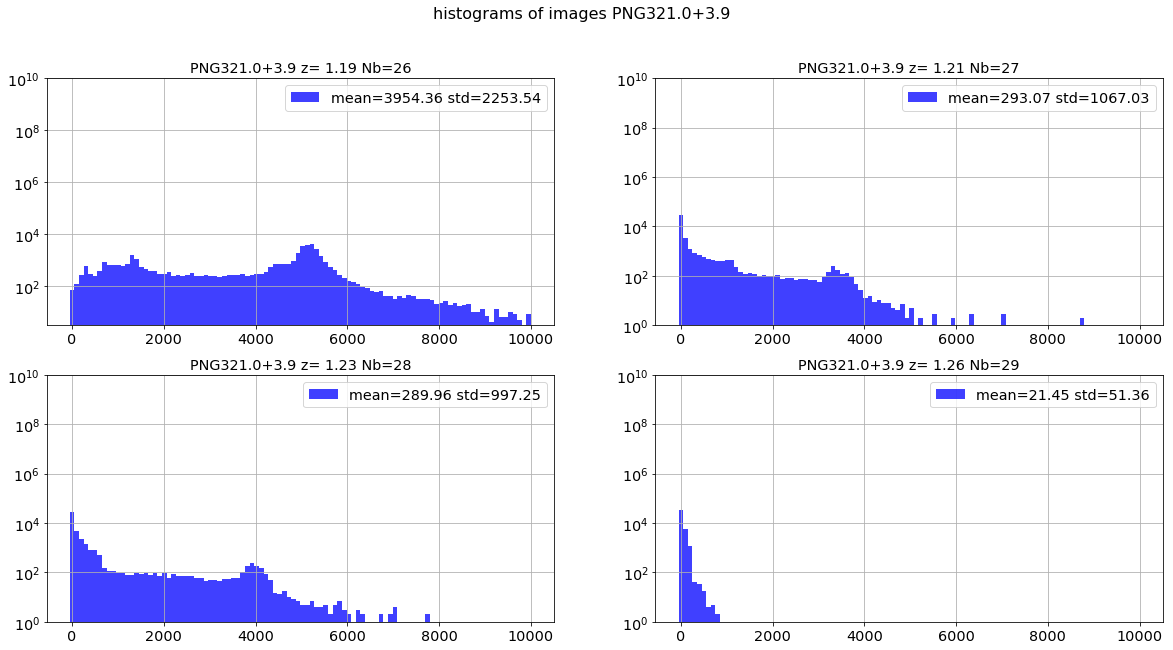

In [8]:
ShowHistograms(all_images,all_titles,all_filt,object_name,
               NBIMGPERROW=2,bins=100,range=(-50,10000),downsampling=10,verbose=True)

### Cut the images

To extract the spectra to analyze

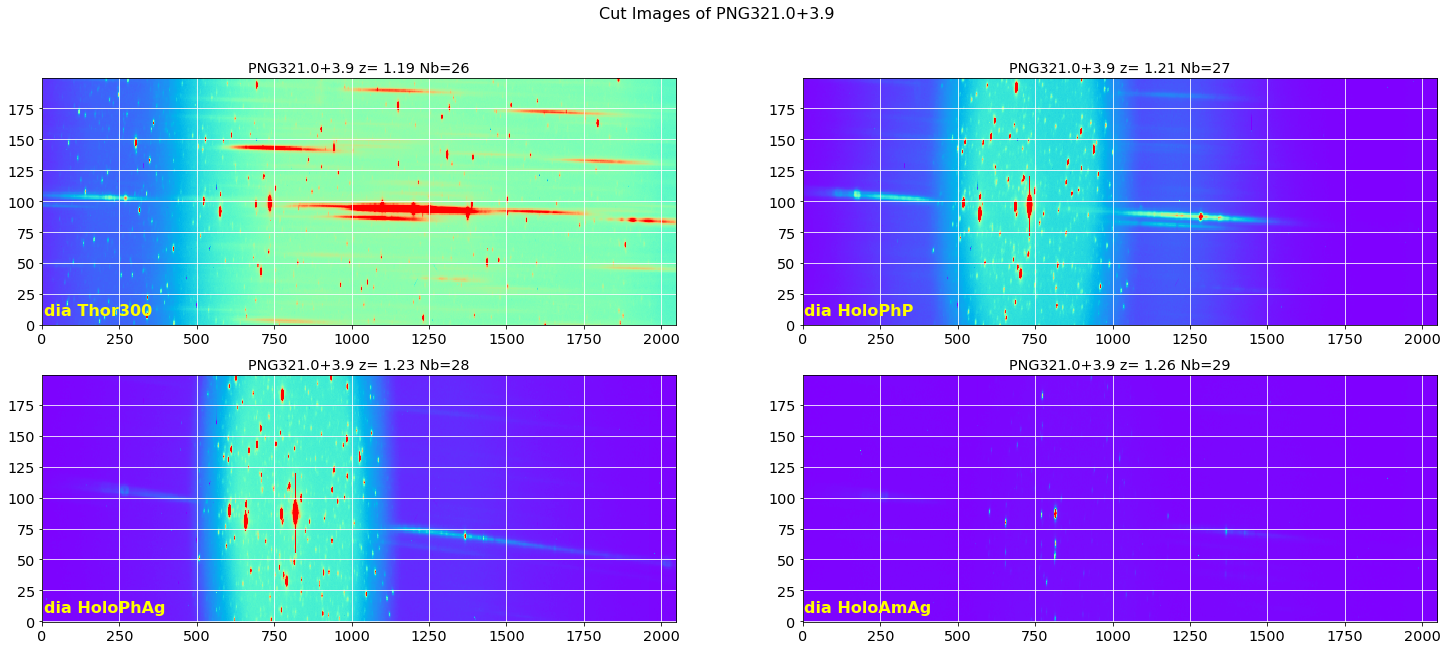

In [53]:
x_guess = [745]*len(all_images)
y_guess = [650,650,600,600]
DeltaY=[100]*len(all_images)
DeltaX=[2000]*len(all_images) # must be very large to have correct order 0 positions

images_raw=ShowCenterImages(x_guess,y_guess,DeltaX,DeltaY,all_images,all_titles,all_filt,object_name,
                            NBIMGPERROW=2,vmin=0,vmax=10000)
figfilename=os.path.join(dir_top_images,'cut_images.pdf')
plt.savefig(figfilename)   

### Save cut images

In [54]:
newfullfilenames=[]
for idx,file in np.ndenumerate(sorted_files):
    short_infilename=file.split("/")[-1]
    short_partfilename=re.findall('^%s_(.*)' % tag,short_infilename)
    short_outfilename='cutimg_'+short_partfilename[0]
    newfullfilename=os.path.join(outputdir,short_outfilename)
    newfullfilenames.append(newfullfilename)
    
for idx,file in np.ndenumerate(newfullfilenames):
    prihdu = fits.PrimaryHDU(header=all_header[idx[0]],data=images_raw[idx[0]])
    thdulist = fits.HDUList(prihdu)
    thdulist.writeto(file,overwrite=True)

!ls -l cut_fitsimages/*

-rw-r--r--  1 jneveu  staff  3288960 11 aoû 15:25 cut_fitsimages/cutimg_20170605_026.fits
-rw-r--r--  1 jneveu  staff  3288960 11 aoû 15:25 cut_fitsimages/cutimg_20170605_027.fits
-rw-r--r--  1 jneveu  staff  3288960 11 aoû 15:25 cut_fitsimages/cutimg_20170605_028.fits
-rw-r--r--  1 jneveu  staff  3288960 11 aoû 15:25 cut_fitsimages/cutimg_20170605_029.fits


# Find the optimal rotation of the spectra
============================

In [55]:
inputdir="./cut_fitsimages"
SelectTagRe='^cutimg_%s_([0-9]+).fits$' % date # regular expression to select the file
SearchTagRe='^cutimg_%s_[0-9]+.fits$' % date

outputdir="./rotated_fitsimages"
ensure_dir(outputdir)

sorted_numbers,sorted_files = MakeFileList([inputdir],MIN_IMGNUMBER,MAX_IMGNUMBER,SelectTagRe,SearchTagRe) 

all_dates,all_airmass,all_images,all_titles,all_header,all_expo,all_filt=BuildImages(sorted_files,sorted_numbers,object_name)

print 'Number of images:',len(all_images)

Number of images: 4


## Find rotation by Hessian analysis

La méthode s'inspire des techniques de détection de filmanents dans le milieu interstellaire.
Elle est décrite dans https://arxiv.org/pdf/1409.6728.pdf section 4.1.
Documentation sur le calcul du Hessien : http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.hessian_matrix

### Test rotation optimal settings

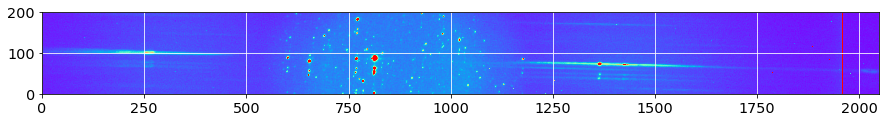

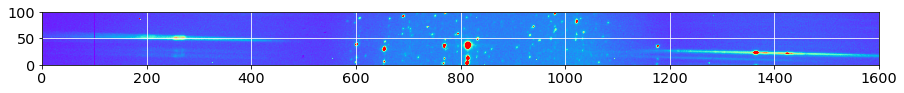

In [56]:
sel=3
image_sel=np.copy(all_images[sel])
y0=DeltaY[sel]
x0=x_guess[sel]

width_cut = 50
right_edge = 1600

plt.imshow(image_sel,origin='lower',cmap='rainbow',vmin=-10,vmax=1000)
plt.grid(color='white', ls='solid')
plt.show()

region=np.copy(image_sel[y0-width_cut:y0+width_cut,0:right_edge])
data=np.copy(region)
plt.imshow(data,origin='lower',cmap='rainbow',vmin=-10,vmax=1000)
plt.grid(color='white', ls='solid')
plt.show()

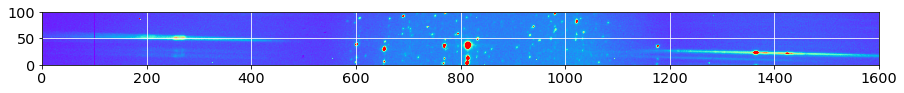

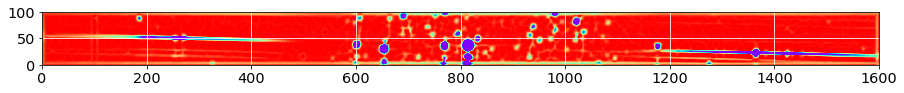

In [57]:
# le paramètre sigma permet de lisser le hessien
Hxx, Hxy, Hyy = hessian_matrix(data, sigma=3, order = 'xy')
lambda_plus = 0.5*( (Hxx+Hyy) + np.sqrt( (Hxx-Hyy)**2 +4*Hxy*Hxy) )
lambda_minus = 0.5*( (Hxx+Hyy) - np.sqrt( (Hxx-Hyy)**2 +4*Hxy*Hxy) )
theta = 0.5*np.arctan2(2*Hxy,Hyy-Hxx)*180/np.pi

plt.imshow(data,origin='lower',cmap='rainbow',vmin=-10,vmax=1000)
plt.grid(color='white', ls='solid')
plt.show()
plt.imshow(lambda_minus,origin='lower',cmap='rainbow',vmin=-10,vmax=0)
plt.grid(color='white', ls='solid')
plt.show()

Number of remaining pixels : 2715


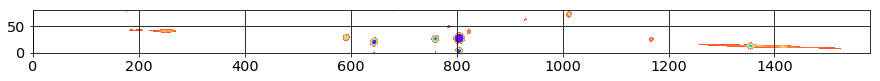

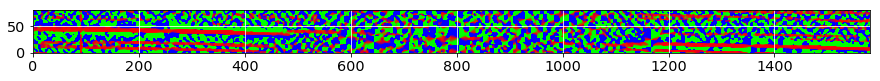

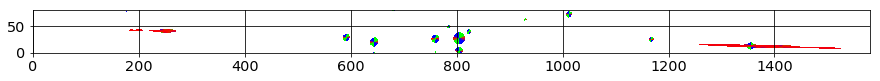

In [58]:
lambda_threshold = -10
margin_cut = 10

lambda_minus = lambda_minus[margin_cut:-margin_cut,margin_cut:-margin_cut]
lambda_plus = lambda_plus[margin_cut:-margin_cut,margin_cut:-margin_cut]
theta = theta[margin_cut:-margin_cut,margin_cut:-margin_cut]

mask = np.where(lambda_minus>lambda_threshold)
lambda_mask = np.copy(lambda_minus)
lambda_mask[mask]=np.nan

theta_mask = np.copy(theta)
theta_mask[mask]=np.nan

print 'Number of remaining pixels :',len(lambda_mask[~np.isnan(lambda_mask)])

plt.imshow(lambda_mask,origin='lower',cmap='rainbow',vmin=-100,vmax=0)
plt.grid(color='black', ls='solid')
plt.show()

plt.imshow(theta,origin='lower',cmap=cm.brg,vmin=-30,vmax=30)
plt.grid(color='white', ls='solid')
plt.show()

plt.imshow(theta_mask,origin='lower',cmap=cm.brg,vmin=-30,vmax=30)
plt.grid(color='black', ls='solid')
plt.show()

Number of remaining pixels : 1140


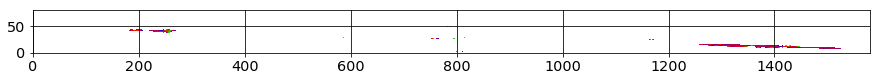

In [59]:
deg_threshold = 5

mask2 = np.where(np.abs(theta)>deg_threshold)
theta_mask[mask2] = np.nan
print 'Number of remaining pixels :',len(theta_mask[~np.isnan(theta_mask)])
plt.imshow(theta_mask,origin='lower',cmap=cm.brg,vmin=-deg_threshold,vmax=deg_threshold)
plt.grid(color='black', ls='solid')
plt.show()

Angle median : -1.28949276589


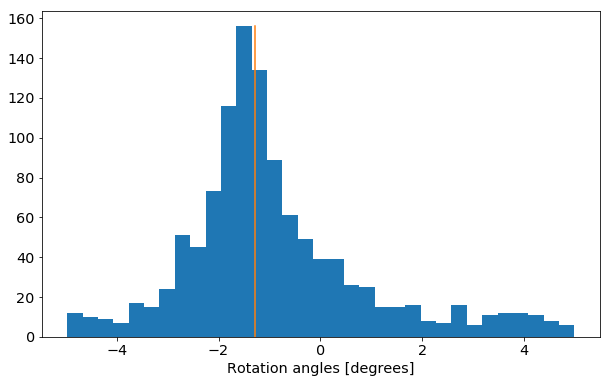

In [60]:
theta_hist = []
theta_hist = theta_mask[~np.isnan(theta_mask)].flatten()
theta_median = np.median(theta_hist)
print 'Angle median :',theta_median
fig = plt.figure(figsize=(10,6))
n,bins, patches = plt.hist(theta_hist,bins=int(np.sqrt(len(theta_hist))))
plt.plot([theta_median,theta_median],[0,np.max(n)])
plt.xlabel("Rotation angles [degrees]")
plt.show()

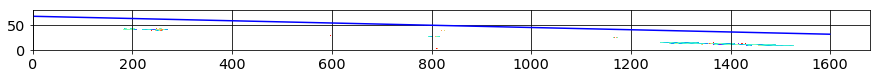

In [61]:
xindex=np.arange(data.shape[1])
x_new = np.linspace(xindex.min(),xindex.max(), 50)
y_new = y0 - width_cut + (x_new-x0)*np.tan(theta_median*np.pi/180.)
plt.imshow(theta_mask,origin='lower',cmap='rainbow',vmin=-deg_threshold,vmax=deg_threshold)
plt.plot(x_new,y_new,'b-')
plt.grid(color='black', ls='solid')
plt.show()

On peut aussi essayer de fitter le spectre qui a été détecté par la méthode ci-dessus.

Rotation angle from fit : -1.42279859307


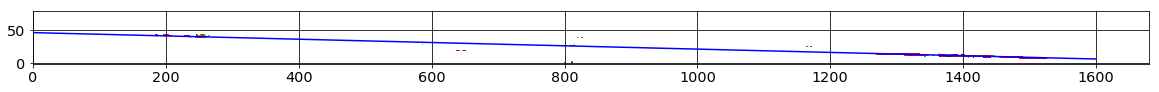

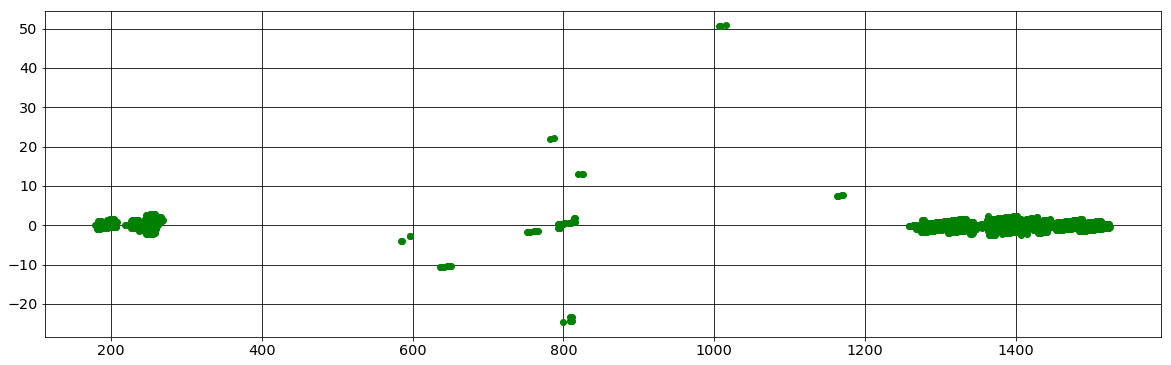

In [62]:
xtofit=[]
ytofit=[]
for iy,y in enumerate(theta_mask):
    for ix,x in enumerate(y):
        if not np.isnan(theta_mask[iy][ix]) :
            if np.abs(theta_mask[iy][ix])>deg_threshold : continue
            xtofit.append(ix)
            ytofit.append(iy)
popt, pcov = fit_line(xtofit, ytofit)
[a, b] = popt
x_new = np.linspace(xindex.min(),xindex.max(), 50)
y_new = line(x_new,a,b)
print 'Rotation angle from fit :',np.arctan(a)*180/np.pi
fig = plt.figure(figsize=[20,6])
plt.imshow(theta_mask,origin='lower',cmap=cm.brg,vmin=-deg_threshold,vmax=deg_threshold)
plt.plot(x_new,y_new,'b-')
plt.grid(color='black', ls='solid')
plt.show()
fig = plt.figure(figsize=[20,6])
diff = []
for ix,x in enumerate(xtofit):
    diff.append(ytofit[ix]-line(x,a,b))
plt.plot(xtofit,diff,'go')
plt.grid(color='black', ls='solid')
plt.show()

Je pense que la méthode de de l'histogramme est plus adaptée à la recherche de spectres continus

Using Hessian theta angles:
0  theta =  -0.373469380097
1  theta =  -0.960392929989
2  theta =  -1.77707960869
3  theta =  -1.28949276589


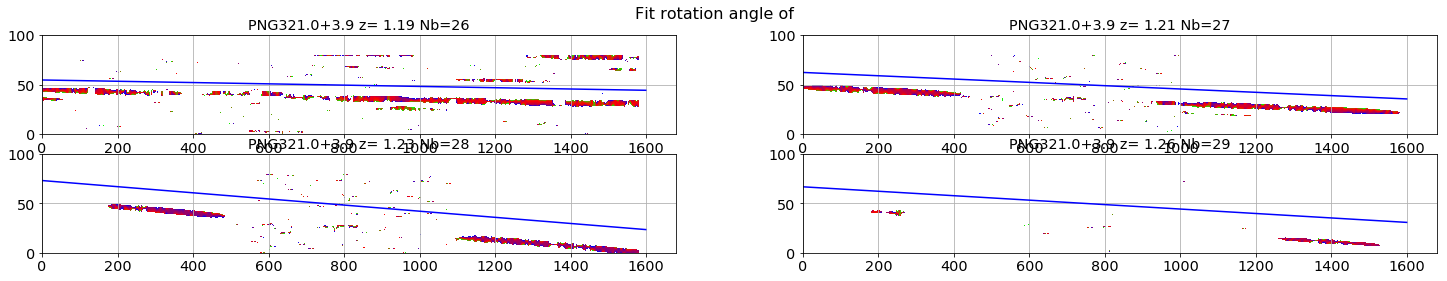

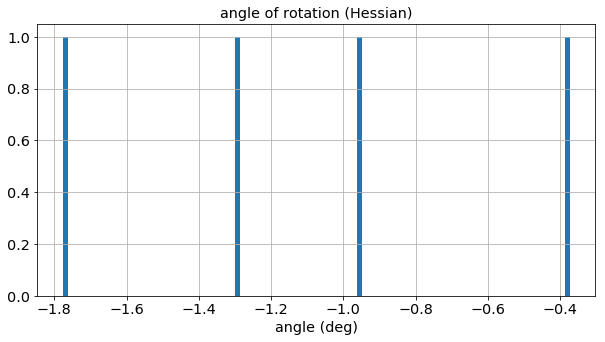

In [63]:
print 'Using Hessian theta angles:'

all_theta=ComputeRotationAngleHessian(all_images,x_guess,DeltaY,all_titles,object_name, 
    NBIMGPERROW=2, lambda_threshold = -10, deg_threshold = 5, width_cut = 50, right_edge = 1600, margin_cut = 10)
figfilename=os.path.join(dir_top_images,'fit_rotation.pdf')
plt.savefig(figfilename)  

for index in range(len(all_theta)):
    print index,' theta = ',all_theta[index]
plt.figure(figsize=(10,5))
n, bins, patches=plt.hist(all_theta,bins=100,histtype='stepfilled')
plt.grid(True)
plt.title('angle of rotation (Hessian)')
plt.xlabel('angle (deg)')

### Turn the images accordingly

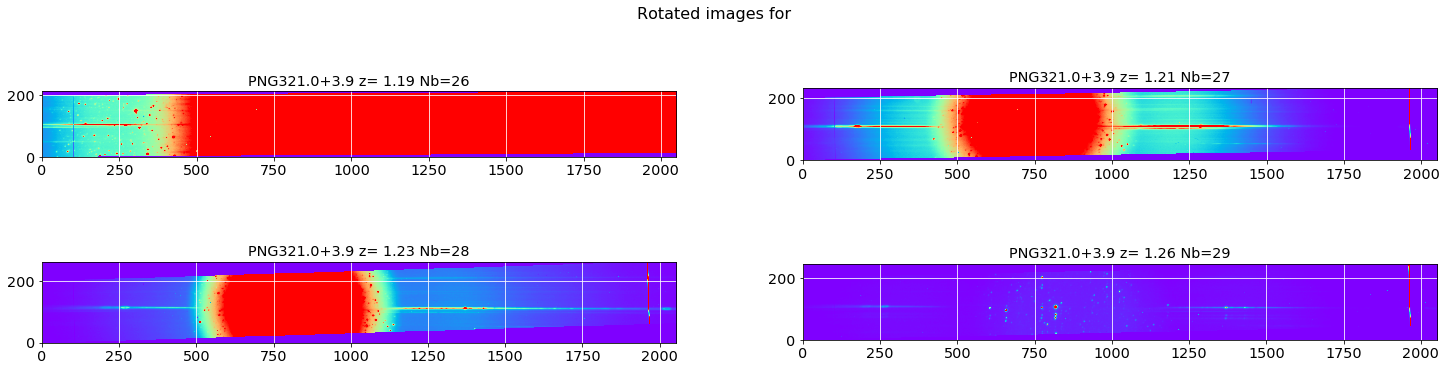

In [64]:
turned_images=TurnTheImages(all_images,all_theta,all_titles,object_name,
                            NBIMGPERROW=2,vmin=50,vmax=3000,oversample_factor=1)
figfilename=os.path.join(dir_top_images,'rotated_images.pdf')
plt.savefig(figfilename)  

### Check rotation

In case of bad rotation, check by eye

array([ 0.00118543, -0.04001326, -0.09007356,  0.00599399])

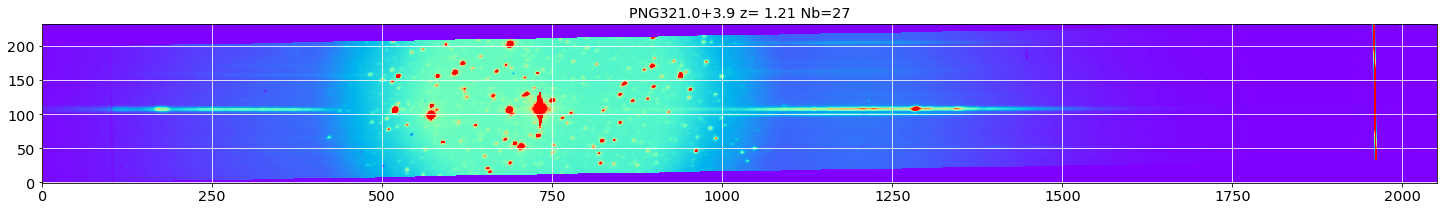

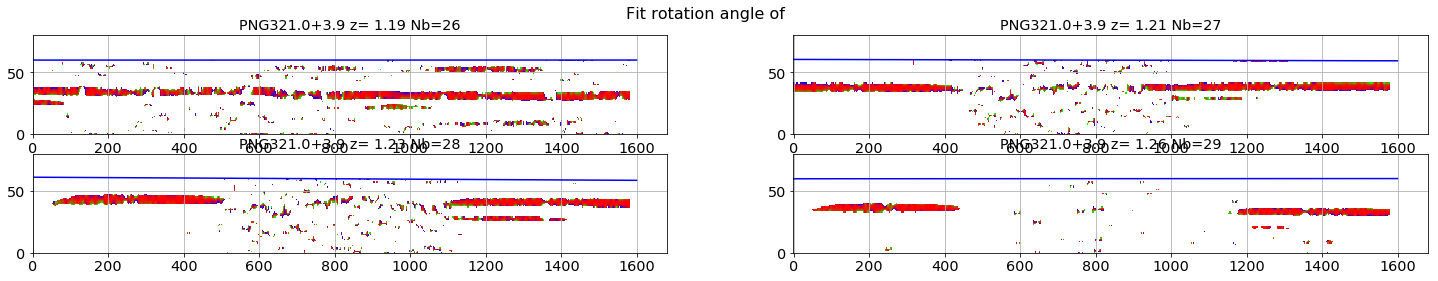

In [65]:
sel=1
plt.figure(figsize=(25,10))
plt.imshow(turned_images[sel],origin='lower',cmap='rainbow',vmin=0,vmax=8000)
plt.grid(True)
plt.title(all_titles[sel])
plt.grid(color='white', ls='solid')
figfilename=os.path.join(dir_top_images,'rotated_image_sample.pdf')
plt.savefig(figfilename)  

ComputeRotationAngleHessian(turned_images,x_guess,DeltaY,all_titles,object_name,
    NBIMGPERROW=2, lambda_threshold = -2, deg_threshold = 10, width_cut = 40, right_edge = 1600, margin_cut = 10)

Cut the extra spectra that pollute the images.

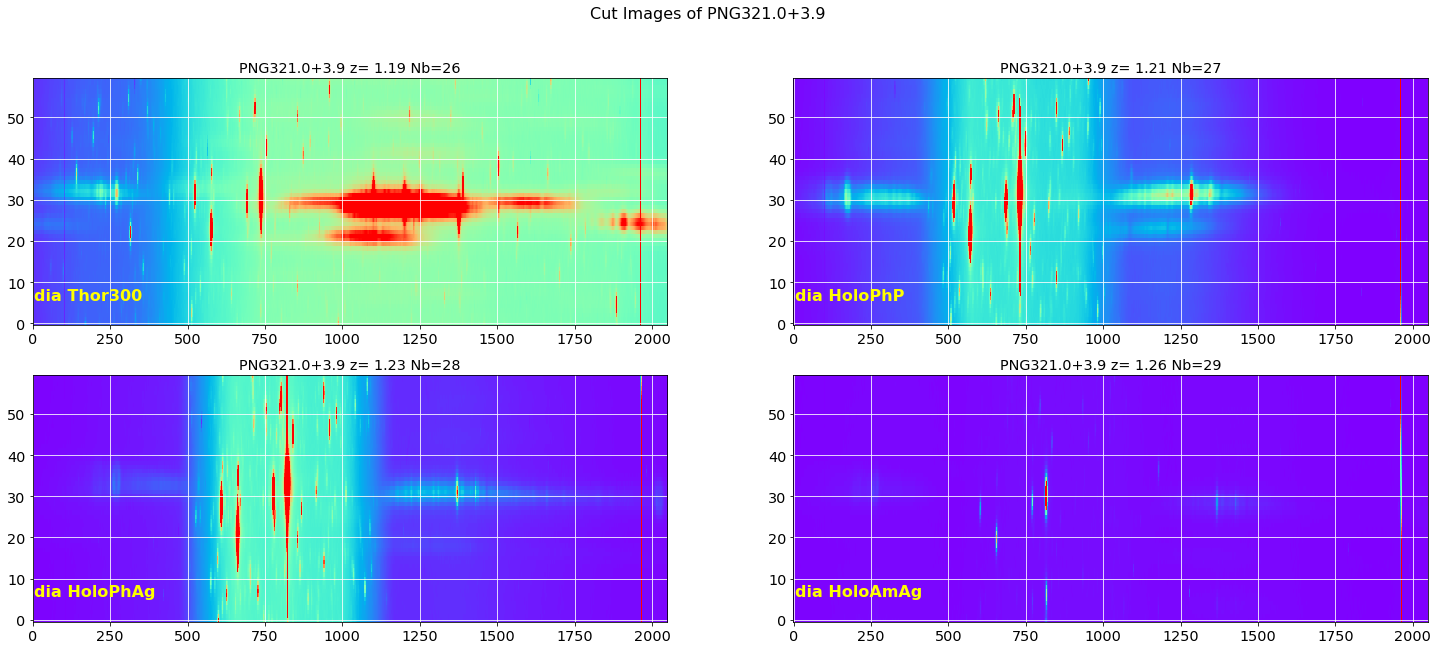

In [66]:
DeltaY_rot2 = [30]*len(all_images)
y_guess_rot2 = [102,107,110,105]
images_cut_rot=ShowCenterImages(x_guess,y_guess_rot2,DeltaX,DeltaY_rot2,
                    turned_images,all_titles,all_filt,object_name,NBIMGPERROW=2,vmin=0,vmax=10000) 

# Find the central star locations
======================================

### Central star positions after rotation and cut

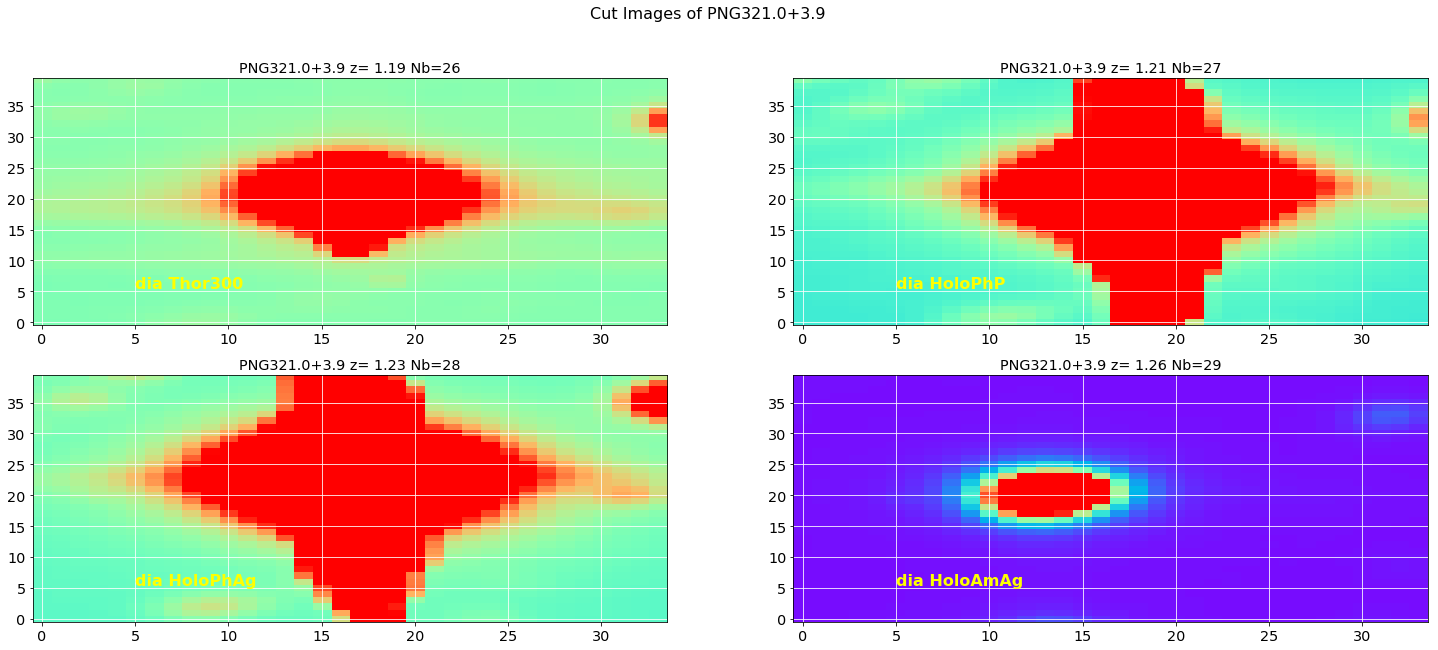

In [118]:
x_guess_rot = [735,730,820,820]
y_guess_rot = DeltaY_rot2
DeltaY_rot = [20]*len(all_images)
DeltaX_rot = [17]*len(all_images)

images_cut=ShowCenterImages(x_guess_rot,y_guess_rot,DeltaX_rot,DeltaY_rot,
                    images_cut_rot,all_titles,all_filt,object_name,NBIMGPERROW=2,vmin=0,vmax=10000) 

In [120]:
# (JN) valeurs optimisées pour cette étude
img_mean,img_median,img_std,img_sources=ComputeStatImages(images_cut,fwhm=9,threshold=3,sigma=10.0,iters=5)

----------------------------------------------------------------
0  mean, median, std =  8677.71130846 5463.79526425 10691.4301622
 id   xcentroid     ycentroid   ...      peak          flux          mag      
--- ------------- ------------- ... ------------- ------------- --------------
  1 16.6667536651 20.4411593386 ... 55128.3504464 4.55413091472 -1.64601377712
----------------------------------------------------------------
1  mean, median, std =  15466.6567517 5026.26851429 19703.0011683
 id   xcentroid     ycentroid   ...     peak          flux           mag      
--- ------------- ------------- ... ------------ ------------- ---------------
  1 17.7224803975 20.6878499371 ... 55423.802346 1.27129743371 -0.260617925766
----------------------------------------------------------------
2  mean, median, std =  15934.9976469 5858.28229362 19171.4945432
 id  xcentroid     ycentroid   ...      peak          flux           mag      
--- ------------ ------------- ... ------------- -----

### Central star position

[[ 734.66675367   30.44115934]
 [ 730.7224804    30.68784994]
 [ 820.36849702   32.61581362]
 [ 816.20927409   30.16769145]]


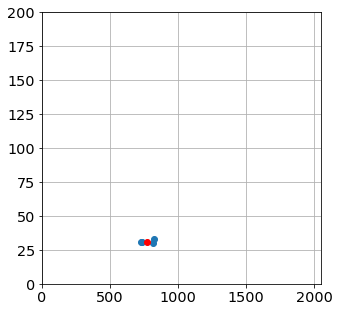

In [121]:
x_star = []
y_star = []
for index,s in enumerate(img_sources):
    for ss in s:
        x_star.append(ss['xcentroid']+x_guess_rot[index]-DeltaX_rot[index])
        y_star.append(ss['ycentroid']+y_guess_rot[index]-DeltaY_rot[index])
        
order0_positions = np.array([x_star,y_star]).T
print order0_positions

x_mean = np.mean(x_star)
y_mean = np.mean(y_star)
img_size=all_images[0].shape
plt.figure(figsize=(5,5))
plt.plot(x_star,y_star,'o')
plt.plot(x_mean,y_mean,'ro')
plt.xlim(0,img_size[1])
plt.ylim(0,img_size[0])
plt.grid(True)

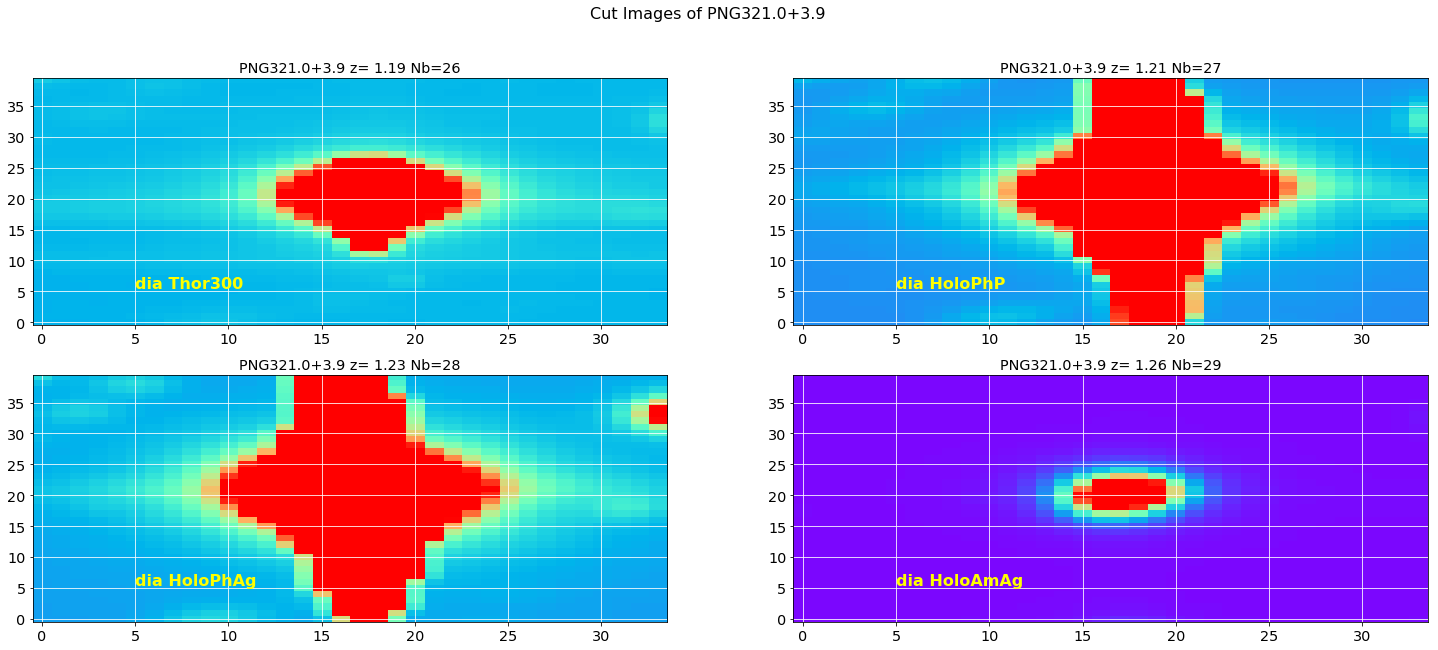

In [122]:
tmp = ShowCenterImages(x_star,y_star,DeltaX_rot,DeltaY_rot,
                    images_cut_rot,all_titles,all_filt,object_name,NBIMGPERROW=2,vmin=0,vmax=20000) 

## Zero order positions before rotations

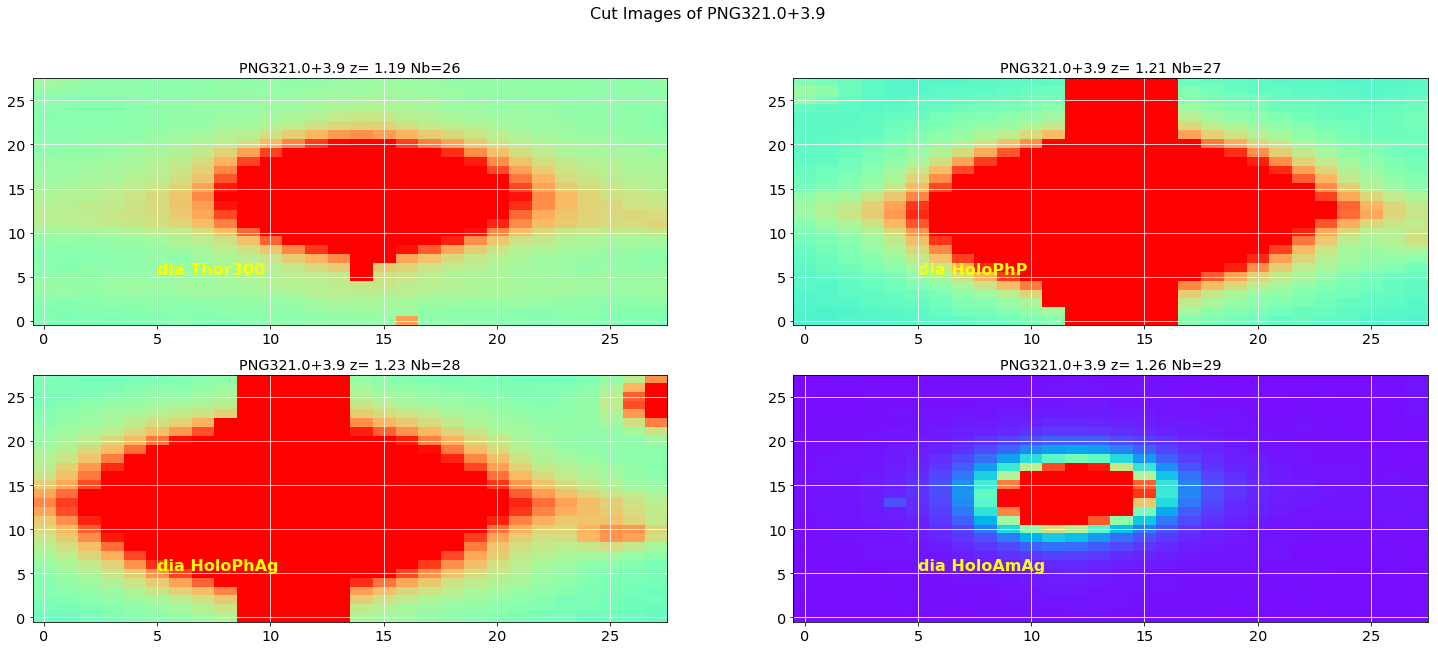

In [189]:
DeltaY_rot = [14]*len(all_images)
DeltaX_rot = [14]*len(all_images)
y_guess2 = [98,98,89,87]
images_raw_cut=ShowCenterImages(x_star,y_guess2,DeltaX_rot,DeltaY_rot,
                    images_raw,all_titles,all_filt,object_name,NBIMGPERROW=2,vmin=0,vmax=10000,mask_saturated=False) 

In [192]:
# (JN) valeurs optimisées pour cette étude
img_mean,img_median,img_std,img_sources=ComputeStatImages(images_raw_cut,fwhm=9,threshold=3,sigma=10.0,iters=5)

----------------------------------------------------------------
0  mean, median, std =  11128.3357704 5855.89594314 14606.2595451
 id   xcentroid     ycentroid   ...      peak          flux          mag      
--- ------------- ------------- ... ------------- ------------- --------------
  1 14.1560869152 13.8194268337 ... 55132.5646871 3.66900448865 -1.41137060768
----------------------------------------------------------------
1  mean, median, std =  20814.672671 6319.99750578 23628.4741708
 id   xcentroid     ycentroid   ...     peak         flux          mag      
--- ------------- ------------- ... ----------- ------------- --------------
  1 14.6703719324 12.4405218975 ... 54443.67771 1.17438321753 -0.17452459088
----------------------------------------------------------------
2  mean, median, std =  21450.2167038 7446.22718074 23022.8080658
 id   xcentroid     ycentroid   ...      peak         flux          mag      
--- ------------- ------------- ... ------------- ------------

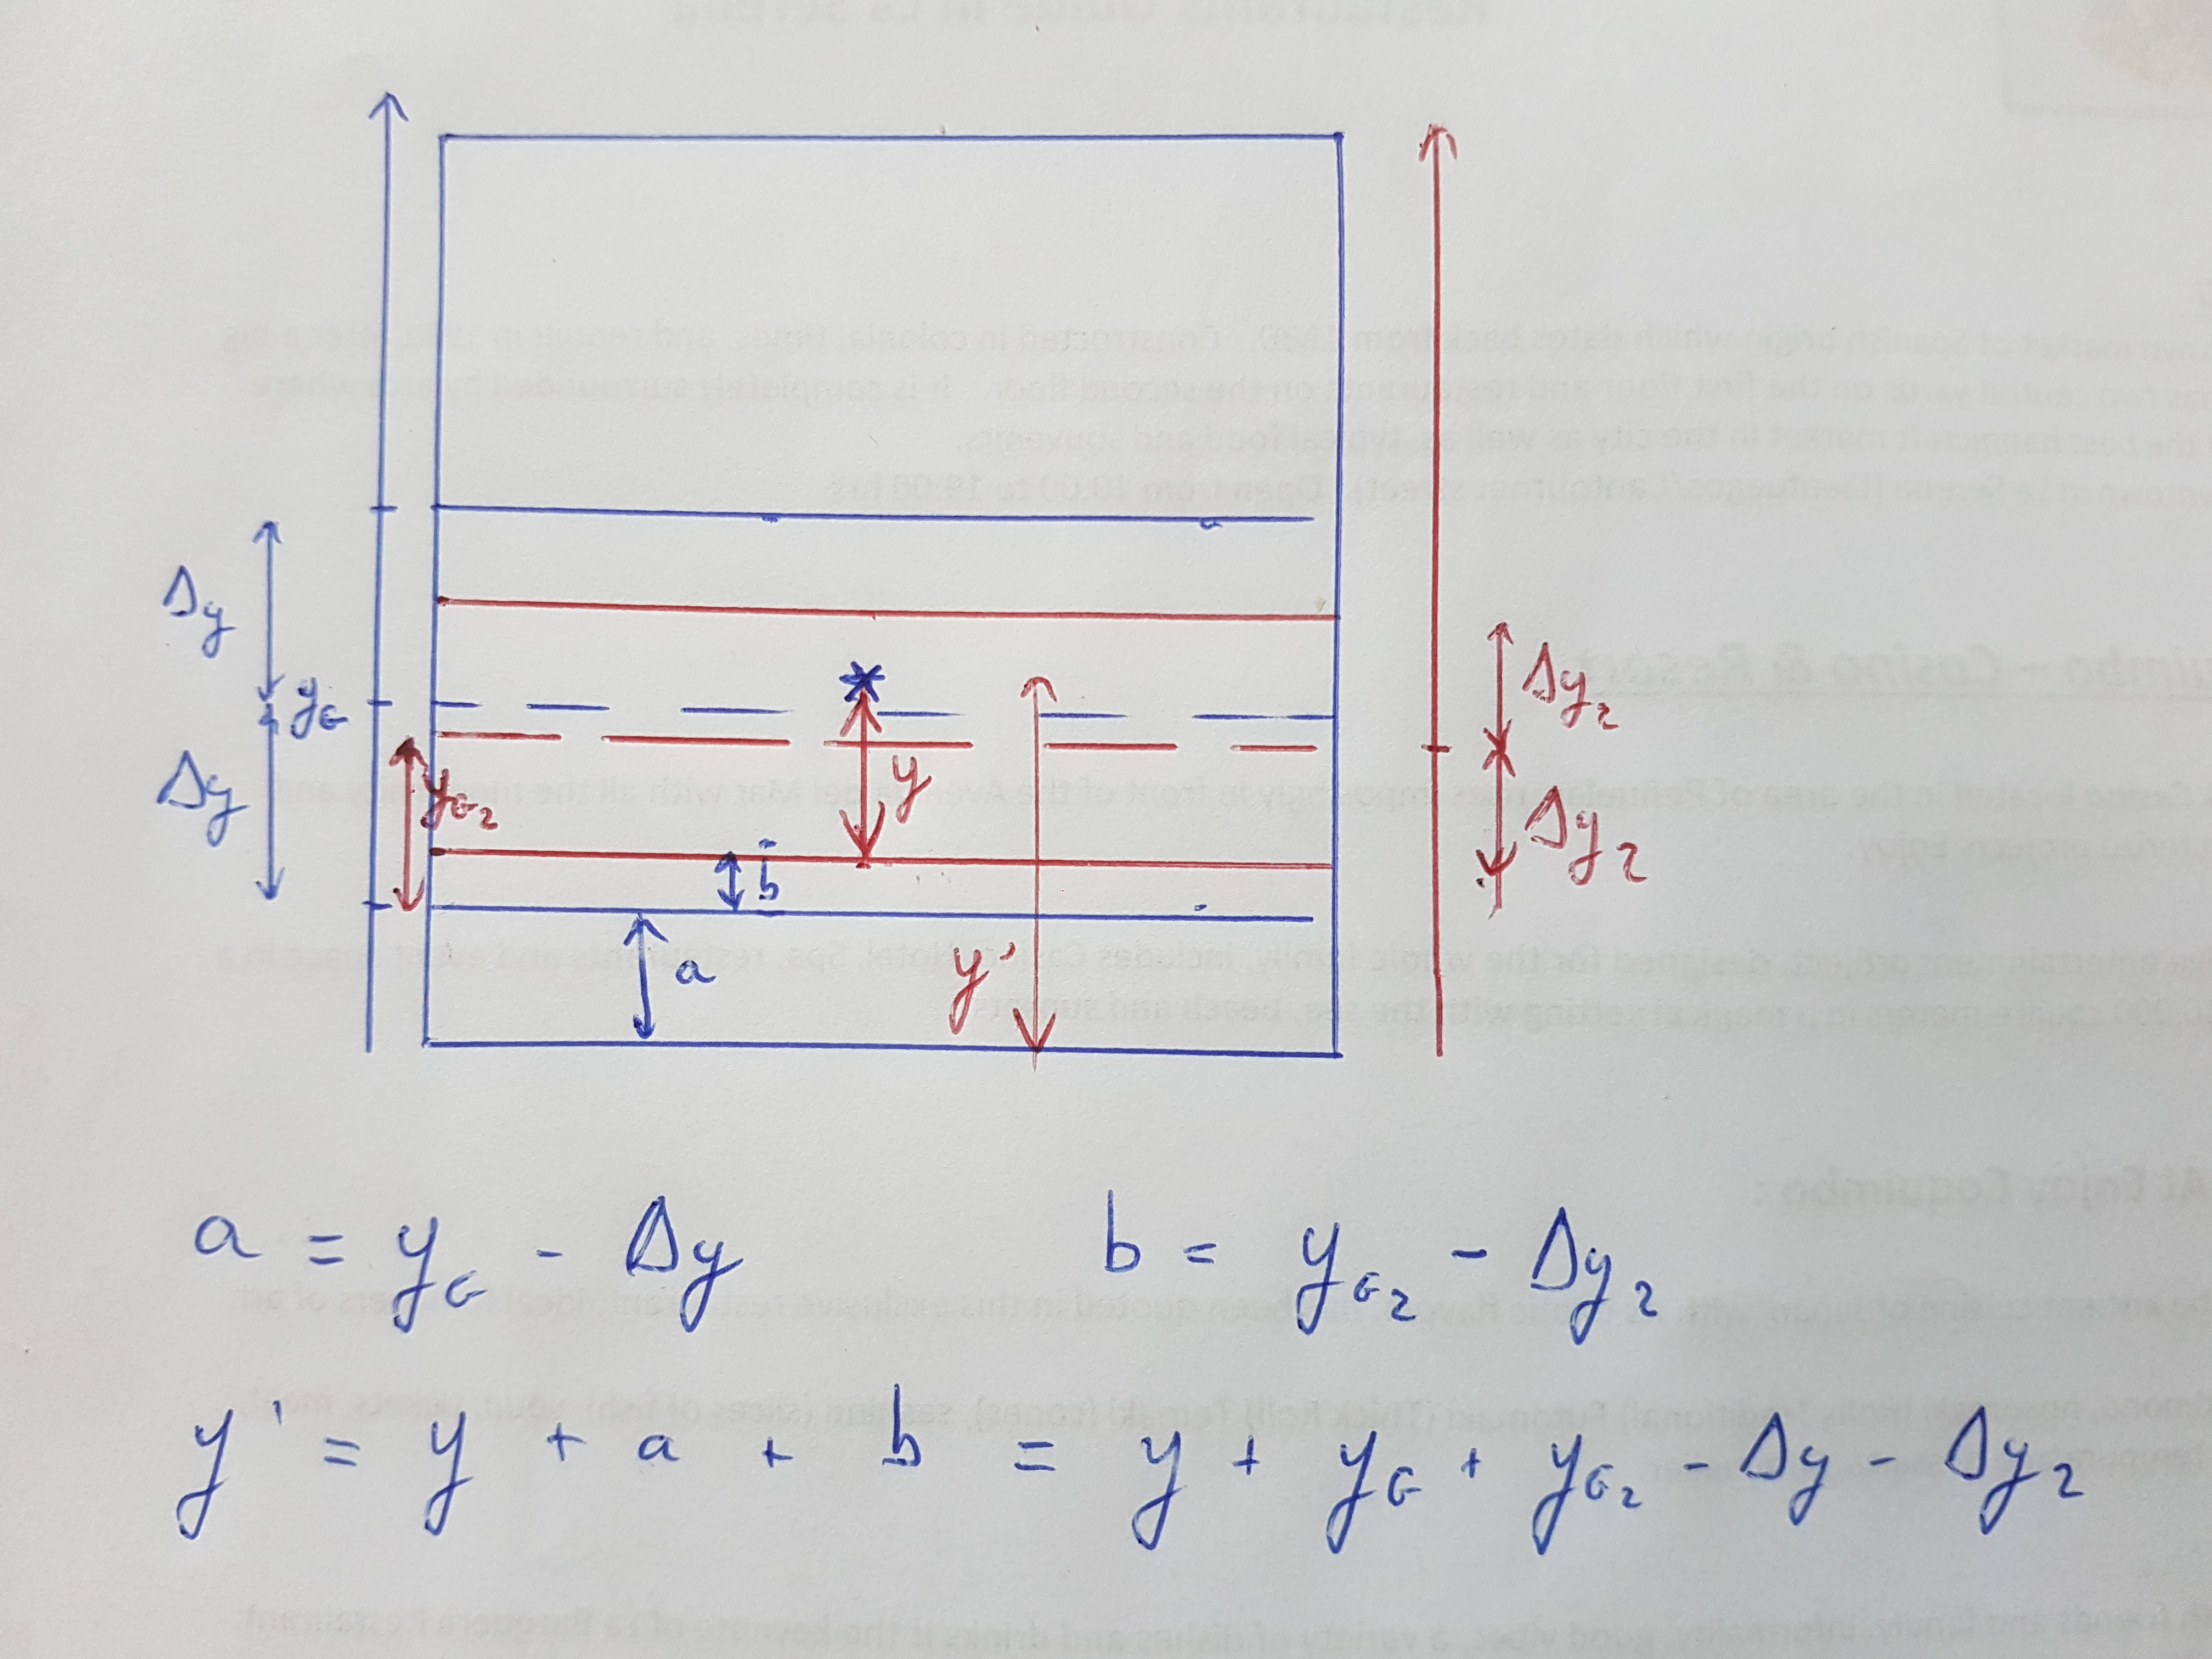

In [215]:
Image(filename='../../common_tools/pictures/image_cuts.jpg')

[[ 734.82284058  647.81942683]
 [ 731.39285233  646.4405219 ]
 [ 818.02323381  587.56643262]
 [ 814.11766399  586.91382171]]
[734.66675366510663, 730.72248039745784, 820.368497019031, 816.20927409125545]


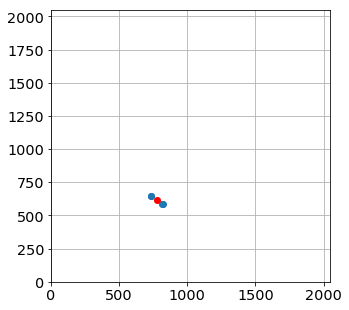

In [212]:
x_pointing = []
y_pointing = []
for index,s in enumerate(img_sources):
    for ss in s:
        x_pointing.append(ss['xcentroid']+x_star[index]-DeltaX_rot[index])
        y_pointing.append(ss['ycentroid']+y_guess[index]+y_guess2[index]-DeltaY_rot[index]-DeltaY[index])
        
x_mean = np.mean(x_pointing)
y_mean = np.mean(y_pointing)
img_size=all_images[0].shape
order0_positions = np.array([x_pointing,y_pointing]).T
print order0_positions
print x_star
plt.figure(figsize=(5,5))
plt.plot(order0_positions.T[0],order0_positions.T[1],'o')
plt.plot(x_mean,y_mean,'ro')
plt.xlim(0,IMSIZE)
plt.ylim(0,IMSIZE)
plt.grid(True)

In [226]:
all_grat = []
for f in all_filt :
    all_grat.append(f.replace('dia ',''))
for index,g in enumerate(all_grat):
    holo = Hologram(g,verbose=False)
    print g,holo.theta(order0_positions[index]), all_theta[index]

Thor300 -0.575 -0.373469380097
HoloPhP [-0.95098611] -0.960392929989
HoloPhAg [-1.84314332] -1.77707960869
HoloAmAg [-1.9320092] -1.28949276589


## Save results

Save the cut images after rotation.

In [213]:
newfullfilenames=[]
for idx,f in np.ndenumerate(sorted_files):
    short_infilename=f.split("/")[2]
    short_partfilename=re.findall('^cutimg_(.*)',short_infilename)
    short_outfilename='rotimg_'+short_partfilename[0]
    newfullfilename=os.path.join(outputdir,short_outfilename)
    newfullfilenames.append(newfullfilename)

for idx,f in np.ndenumerate(newfullfilenames):
    prihdu = fits.PrimaryHDU(header=all_header[idx[0]],data=images_cut_rot[idx[0]])
    thdulist = fits.HDUList(prihdu)
    thdulist.writeto(f,overwrite=True)
textfilename=os.path.join(outputdir,'star_centroids.txt')
print textfilename
np.savetxt(textfilename,order0_positions,header="y_star x_star",fmt='%d')

!ls -l rotated_fitsimages

IndexError: list index out of range

# Extract spectra
===================================

In [197]:
outputdir="./spectrum_fitsspec"
ensure_dir(outputdir)

inputdir="./rotated_fitsimages"
SelectTagRe='^rotimg_%s_([0-9]+).fits$' % date # regular expression to select the file
SearchTagRe='^rotimg_%s_[0-9]+.fits$' % date

sorted_numbers,sorted_files = MakeFileList([inputdir],MIN_IMGNUMBER,MAX_IMGNUMBER,SelectTagRe,SearchTagRe) 

all_dates,all_airmass,all_images,all_titles,all_header,all_expo,all_filt=BuildImages(sorted_files,sorted_numbers,object_name)

print 'Number of images:',len(all_images)

Number of images: 4


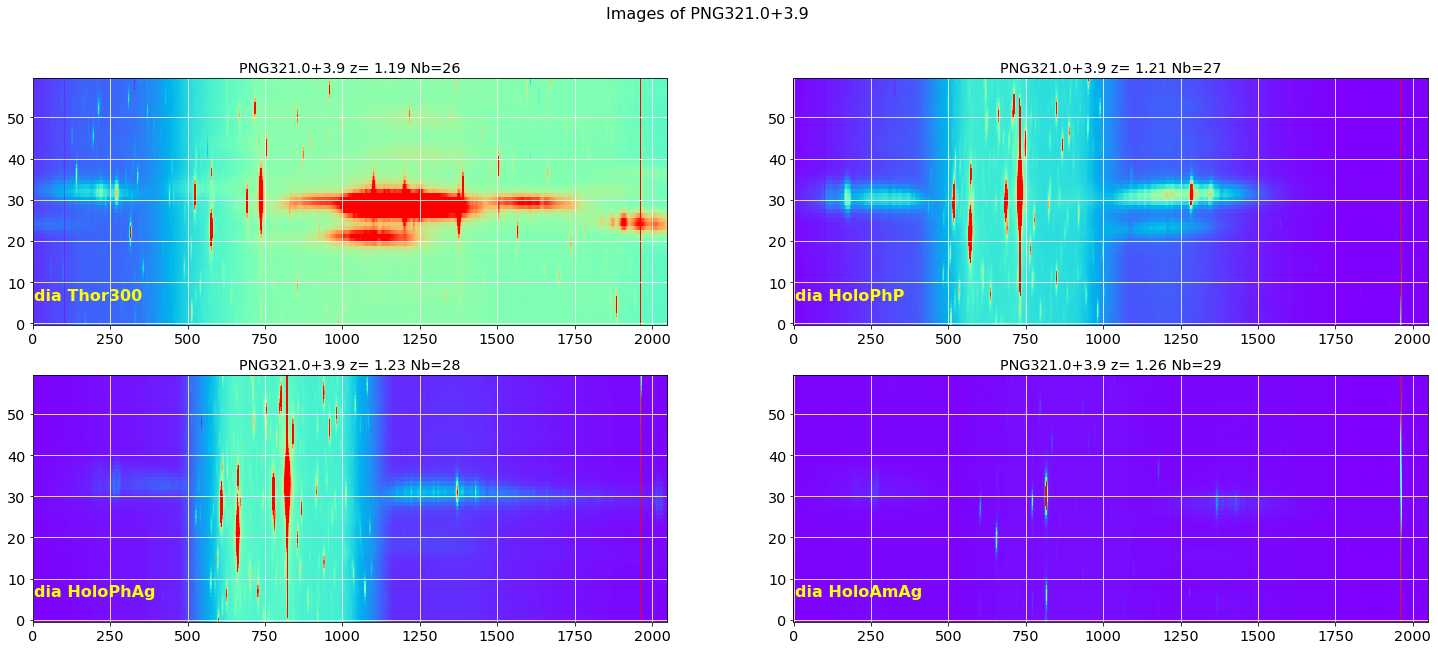

In [198]:
ShowImages(all_images,all_titles,all_filt,object_name,NBIMGPERROW=2,vmin=0,vmax=10000)

[30.441159338635799, 30.687849937055717, 32.615813615766584, 30.167691448715246]


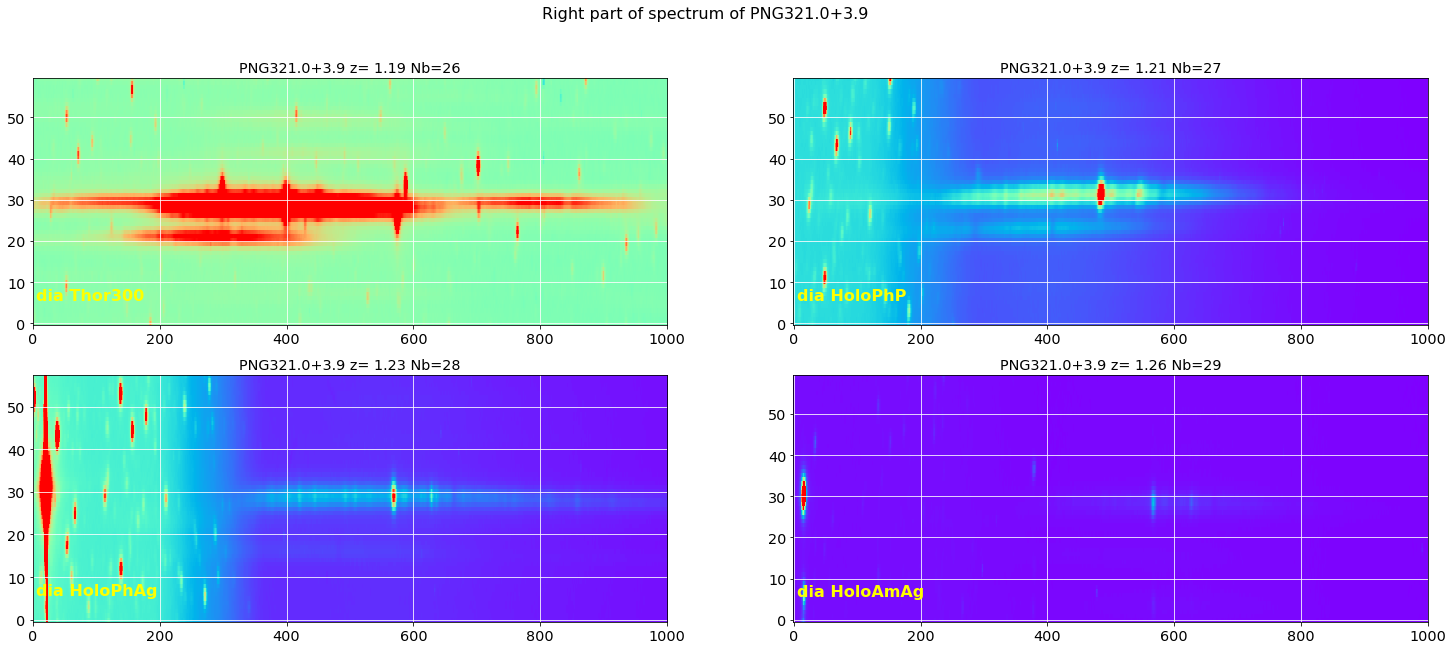

In [199]:
# Right spectrum
print y_star
ShowCenterImages([1300]*len(all_images),y_star,[500]*len(all_images),[30]*len(all_images),
                 all_images,all_titles,all_filt,object_name,NBIMGPERROW=2,vmin=0,vmax=10000)
title='Right part of spectrum of {} '.format(object_name)
plt.suptitle(title,size=16)
figfilename=os.path.join(dir_top_images,'rightorder.pdf')
plt.savefig(figfilename)  

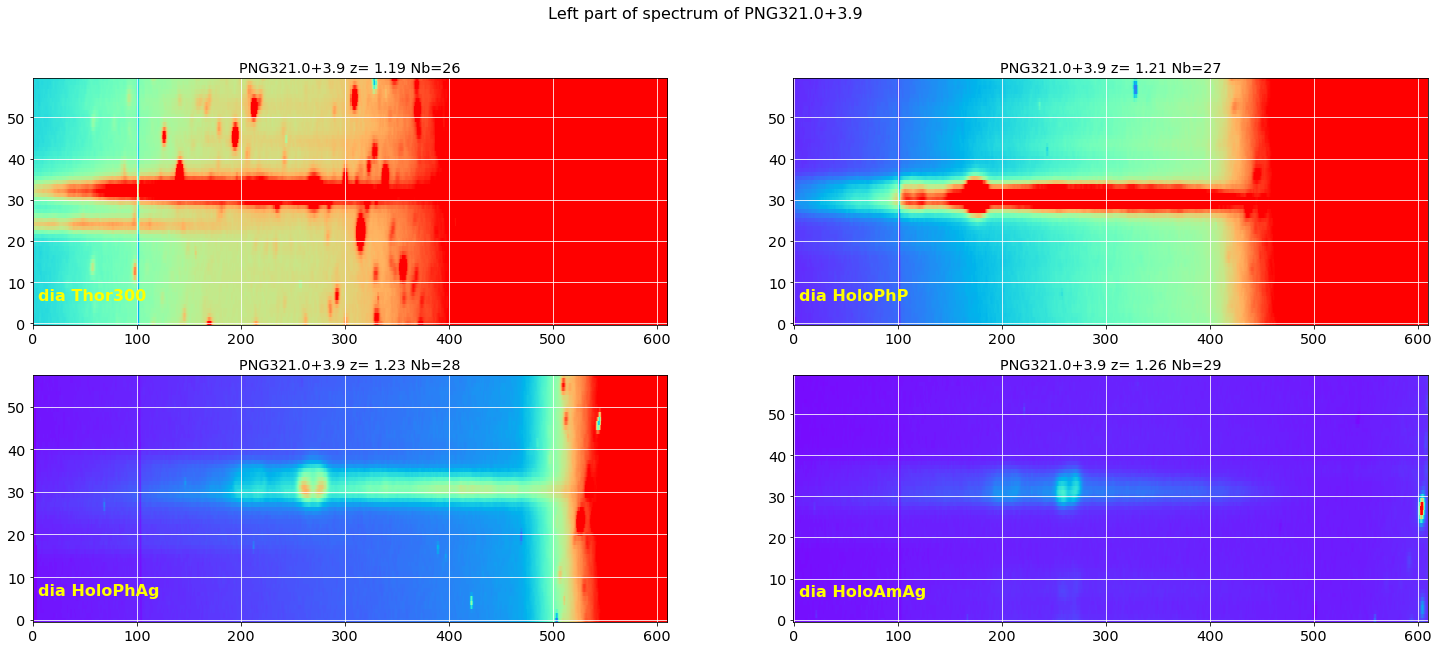

In [200]:
# Left spectrum
ShowCenterImages([110]*len(all_images),y_star,[500]*len(all_images),[30]*len(all_images),
                 all_images,all_titles,all_filt,object_name,NBIMGPERROW=2,vmin=0,vmax=2000)
title='Left part of spectrum of {} '.format(object_name)
plt.suptitle(title,size=16)
figfilename=os.path.join(dir_top_images,'leftorder.pdf')
plt.savefig(figfilename)  

### Extraction

[29, 31, 31, 30]

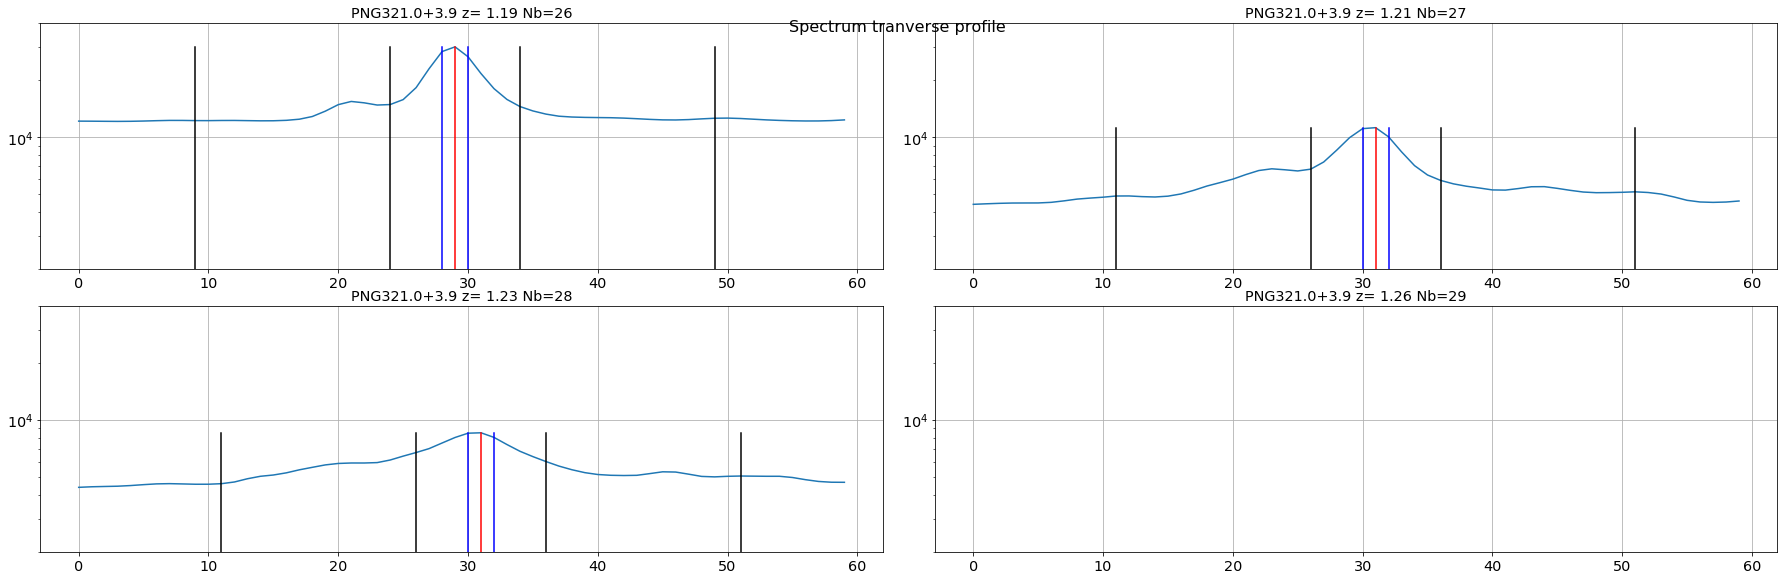

In [201]:
ShowTransverseProfile(all_images,all_titles,object_name,all_expo,NBIMGPERROW=2,
                      DeltaX=1000,w=1,ws=[5,20],right_edge=1800,ylim=(2e3,4e4))

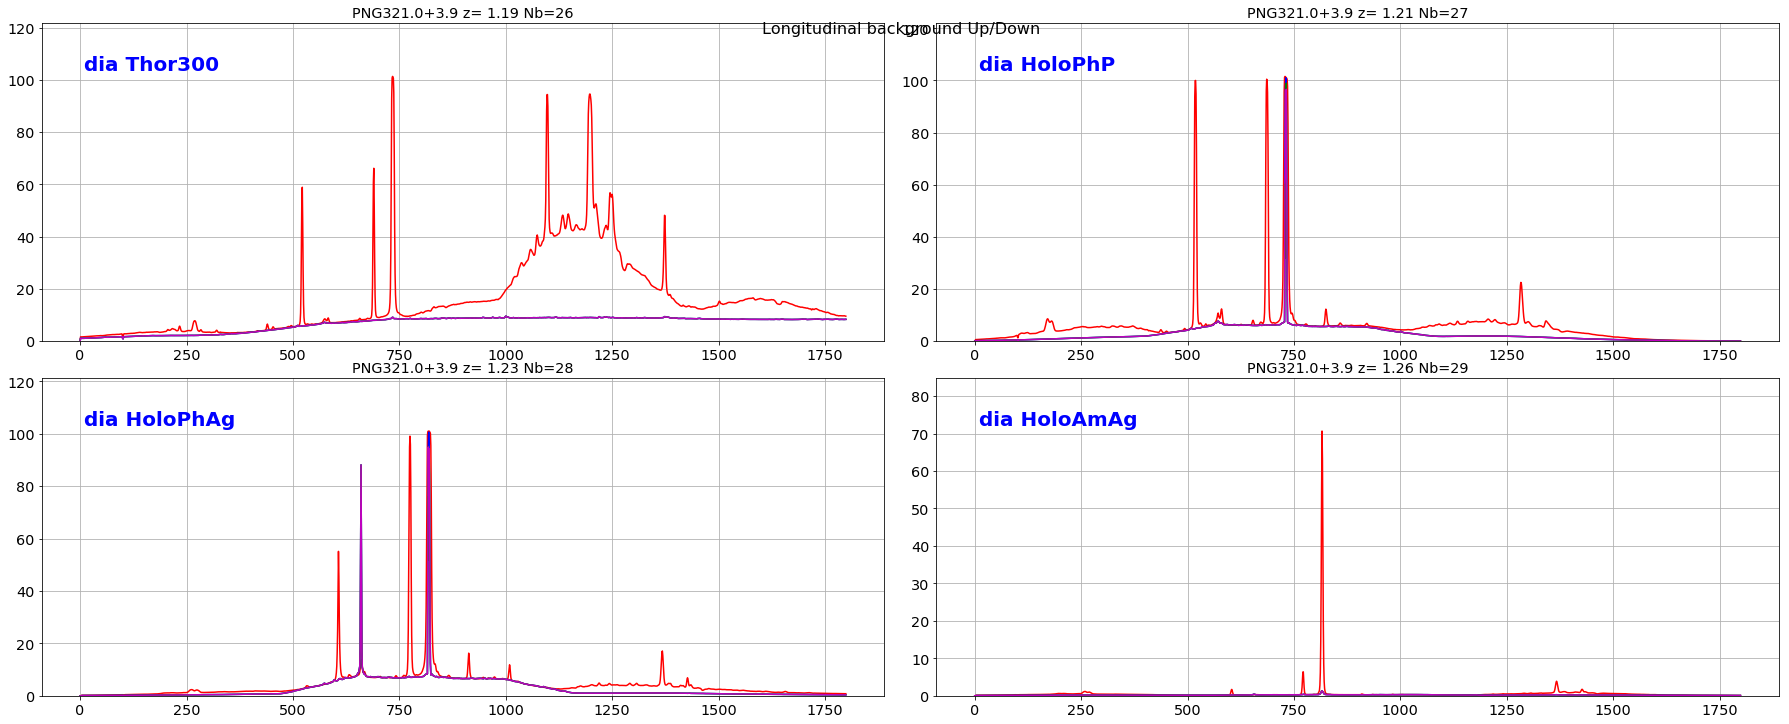

In [202]:
thespectra,thespectraUp,thespectraDown=ExtractSpectra(y_star,all_images,all_titles,object_name,all_expo,
                                                      w=1,ws=[5,30],right_edge=1800)

Clean_Up, Clean_Do,Clean_Av=CleanBadPixels(thespectraUp,thespectraDown) 

ShowLongitBackground(thespectra,Clean_Up,Clean_Do,Clean_Av,all_titles,all_filt,object_name,
                     NBIMGPERROW=2,right_edge=1800)
figfilename=os.path.join(dir_top_images,'background_longprofile.pdf')
plt.savefig(figfilename)   

(0, 20.0)

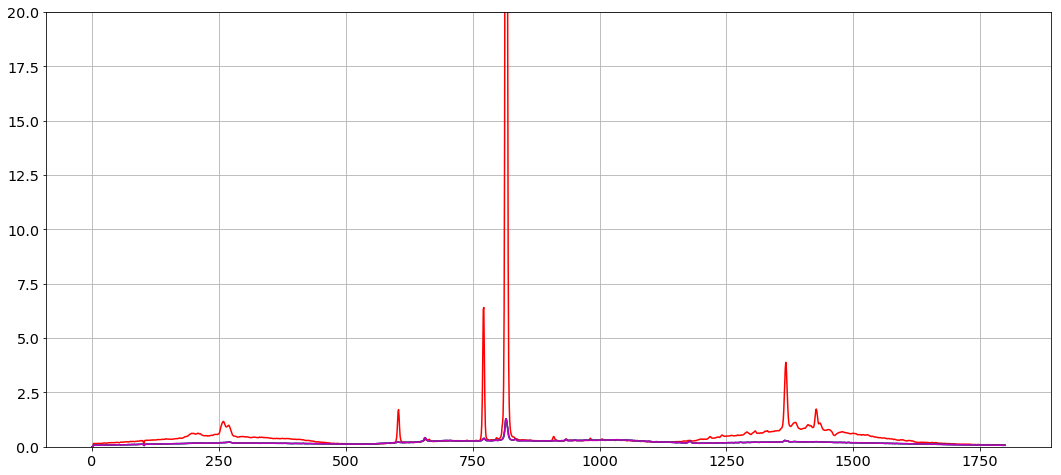

In [203]:
sel=3
plt.figure(figsize=(18,8))
plt.plot(thespectra[sel],'r-') 
plt.plot(Clean_Up[sel],'b-') 
plt.plot(Clean_Do[sel],'g-')
plt.plot(Clean_Av[sel],'m-')
plt.grid(True)
plt.ylim(0,20.)

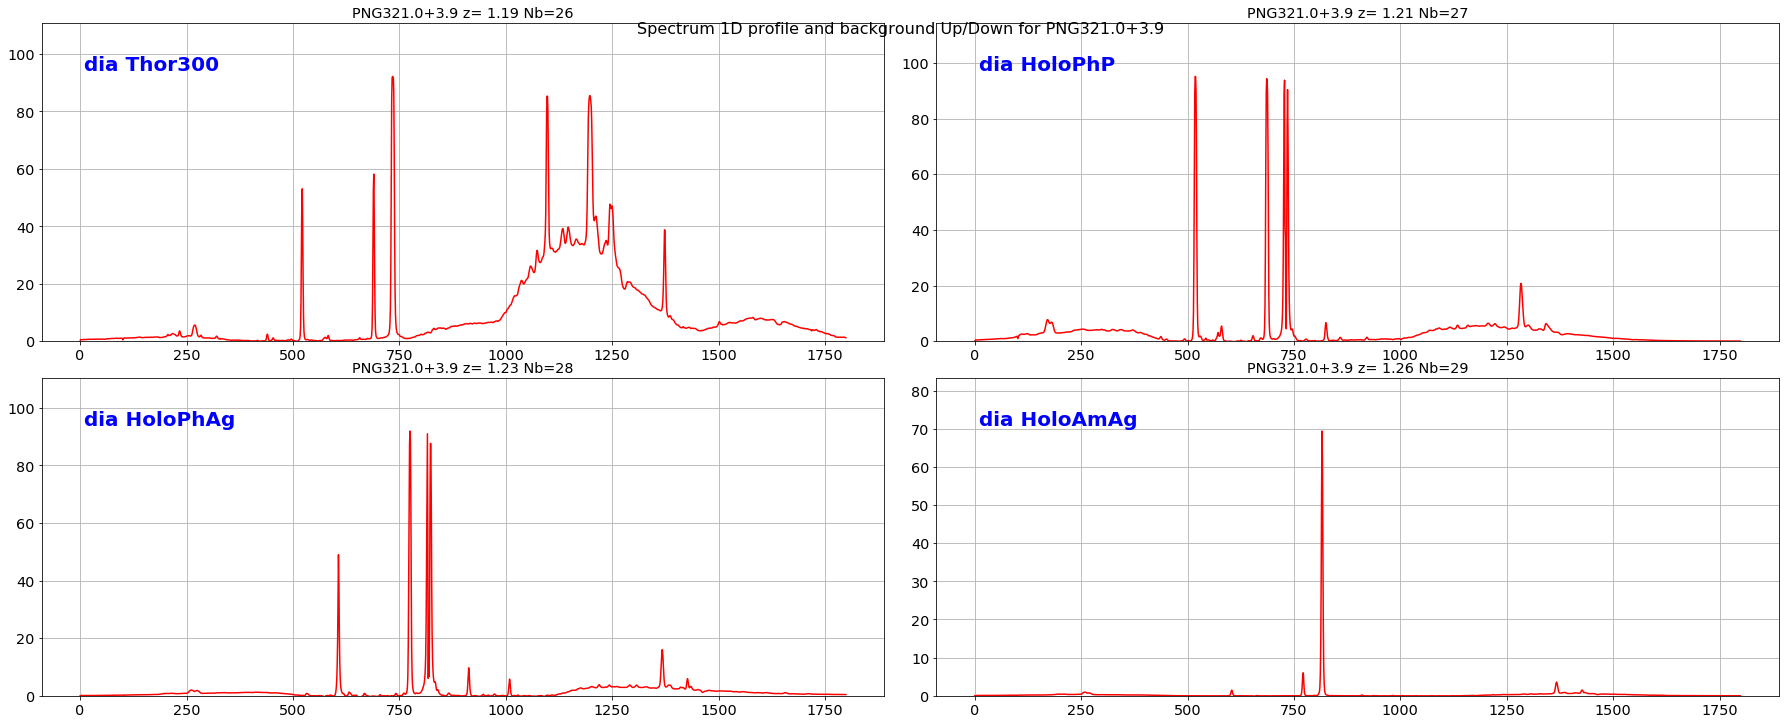

In [204]:
thecorrspectra=CorrectSpectrumFromBackground(thespectra,Clean_Av)

ShowSpectrumProfile(thecorrspectra,all_titles,object_name,all_filt,NBIMGPERROW=2)
figfilename=os.path.join(dir_top_images,'correctedspectrum_profile.pdf')
plt.savefig(figfilename) 

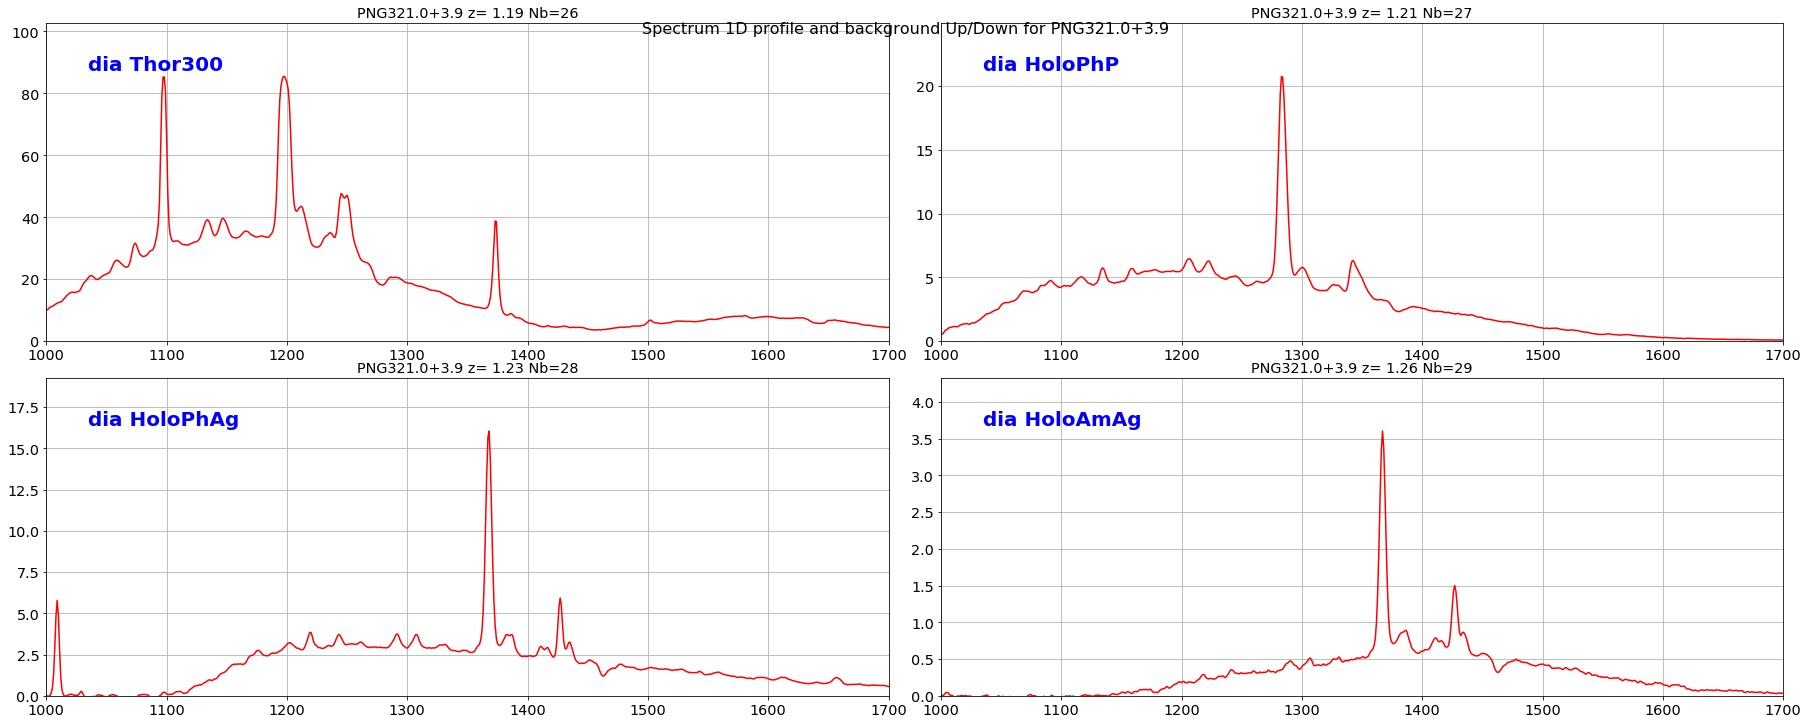

In [205]:
ShowSpectrumProfile(thecorrspectra,all_titles,object_name,all_filt,NBIMGPERROW=2,xlim=(1000,1700))
figfilename=os.path.join(dir_top_images,'correctedspectrum_rightprofile.pdf')
plt.savefig(figfilename) 

# Emission line identification

Load hologram Thor300:
Plate center at x0 = 774.0 and y0 = 690.7 with average tilt of -0.6 degrees
Hologram center at x0 = 1398.0 and y0 = 1264.0 with average tilt of -0.6 degrees
Order  0 position at x0 = 1172.7 and y0 = 1266.3
Order +1 position at x0 = 1623.3 and y0 = 1261.7
Distance between the orders: 450.55 pixels (10.81 mm)
-----------------------------------------------------
Load hologram HoloPhP:
Plate center at x0 = 774.0 and y0 = 690.7 with average tilt of -1.0 degrees
Hologram center at x0 = 856.0 and y0 = 562.3 with average tilt of -1.0 degrees
Order  0 position at x0 = 590.7 and y0 = 567.2
Order +1 position at x0 = 1121.3 and y0 = 557.5
Distance between the orders: 530.76 pixels (12.74 mm)
-----------------------------------------------------
Load hologram HoloPhAg:
Plate center at x0 = 774.0 and y0 = 690.7 with average tilt of -1.9 degrees
Hologram center at x0 = 1044.2 and y0 = 606.7 with average tilt of -1.9 degrees
Order  0 position at x0 = 779.6 and y0 = 614.7
Order 

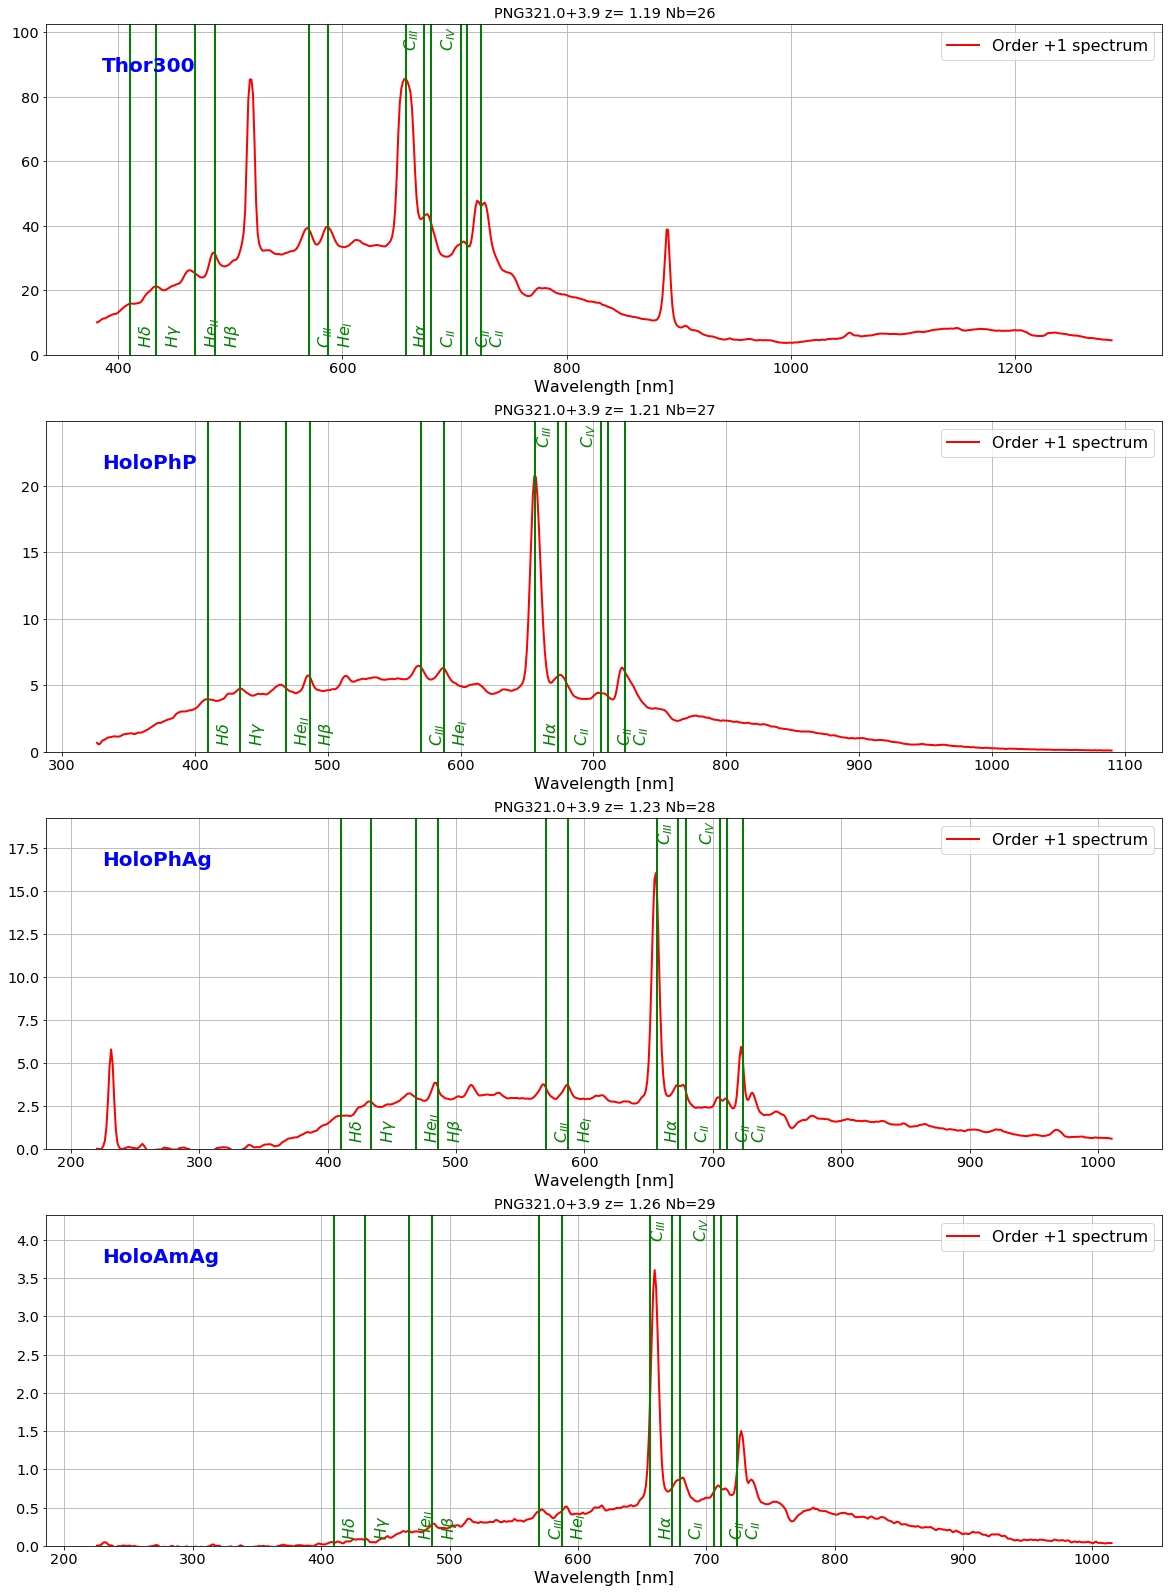

In [223]:
all_grat = []
for f in all_filt :
    all_grat.append(f.replace('dia ',''))

CalibrateSpectra(thecorrspectra,0,x_star,order0_positions,all_titles,object_name,all_grat,
                 xlim=(1000,1700),target=None,order=1,dir_top_images=dir_top_images) 

### Main conclusions

- The lines are bright but the background substraction was difficult close to the circular mask : make squared mask !
- The hologram effective grooves per mm number is overestimated for holograms : variations depending on the pointing ?
- FWHMs are ...

## Save results

In [224]:
newfullfilenames=[]
for idx,f in np.ndenumerate(sorted_files):
    short_infilename=f.split("/")[-1]
    short_partfilename=re.findall('^rotimg_(.*)',short_infilename)
    short_outfilename='finalSpectra_'+short_partfilename[0]
    newfullfilename=os.path.join(outputdir,short_outfilename)
    newfullfilenames.append(newfullfilename)
    
for idx,f in np.ndenumerate(newfullfilenames):
    prihdu = fits.PrimaryHDU(header=all_header[idx[0]],data=thecorrspectra[idx[0]])
    thdulist = fits.HDUList(prihdu)
    thdulist.writeto(f,clobber=True)
    
%ls -l spectrum_fitsspec

total 224
-rw-r--r--  1 jneveu  staff  25920 11 aoû 17:35 finalSpectra_20170605_026.fits
-rw-r--r--  1 jneveu  staff  25920 11 aoû 17:35 finalSpectra_20170605_027.fits
-rw-r--r--  1 jneveu  staff  25920 11 aoû 17:35 finalSpectra_20170605_028.fits
-rw-r--r--  1 jneveu  staff  25920 11 aoû 17:35 finalSpectra_20170605_029.fits
